# Task 3 Classification 

#### Group: B (Joseph Weibel / Rebecka Fahrni)

In [100]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from skmultilearn.model_selection import IterativeStratification
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import torch.nn as nn
import torch.nn.functional as F
from transformers.utils import logging
import wandb
import os

In [2]:
data = load_dataset('argilla/medical-domain')['train']
df = data.to_pandas()

# add label and text length
df['labels'] = df.prediction.apply(lambda x: x[0]['label'])
df = df.set_index('text')
df.shape


(4966, 13)

In [3]:
df_ohe = pd.get_dummies(df['labels'])
df_ohe = df_ohe.groupby(df_ohe.index).sum()
df_ohe.shape

(2357, 40)

In [6]:
df_duplicate_labels = (df_ohe > 1).sum(axis=1)
df_duplicate_labels = df_duplicate_labels[df_duplicate_labels > 0]
print(f'There are {len(df_duplicate_labels)} duplicate labels.')

There are 0 duplicate labels.


In [7]:
df_ohe = df_ohe.clip(upper=1)

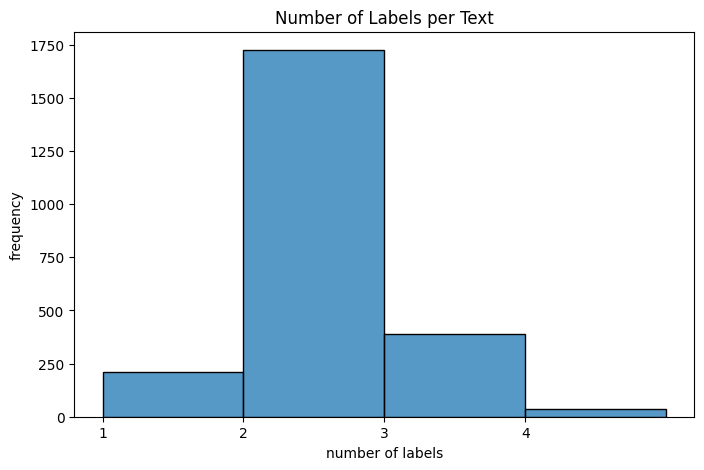

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ohe.sum(axis=1), binwidth=1)
plt.title('Number of Labels per Text')
plt.xlabel('number of labels')
plt.ylabel('frequency')
plt.xticks([1, 2, 3, 4])
plt.show()

In [9]:
df_ohe = df_ohe.drop(columns=df_ohe.columns[df_ohe.sum(axis=0) < 25])
df_ohe.shape

(2357, 26)

In [10]:
df_ohe.sum(axis=0)

 Cardiovascular / Pulmonary        371
 Consult - History and Phy.        516
 Cosmetic / Plastic Surgery         27
 Dentistry                          27
 Dermatology                        29
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Emergency Room Reports             75
 Gastroenterology                  224
 General Medicine                  259
 Hematology - Oncology              90
 Nephrology                         81
 Neurology                         223
 Neurosurgery                       94
 Obstetrics / Gynecology           155
 Office Notes                       50
 Ophthalmology                      83
 Orthopedic                        355
 Pain Management                    59
 Pediatrics - Neonatal              70
 Podiatry                           47
 Psychiatry / Psychology            53
 Radiology                         273
 SOAP / Chart / Progress Notes     166
 Surgery                          1088
 Urology                 

## Evaluation

In [11]:
n_splits = 5

if not os.path.exists('./data/fold_0_train.csv'):
	k_fold = IterativeStratification(n_splits=n_splits, order=1)
	for idx, (train_idx, test_idx) in enumerate(k_fold.split(df_ohe.index, df_ohe.values)):
		train, test = df_ohe.iloc[train_idx], df_ohe.iloc[test_idx]

		train.to_csv(f'./data/fold_{idx}_train.csv')
		test.to_csv(f'./data/fold_{idx}_test.csv')


In [12]:
splits = []
for idx in range(n_splits):
	train = pd.read_csv(f'./data/fold_{idx}_train.csv', index_col=0)
	test = pd.read_csv(f'./data/fold_{idx}_test.csv', index_col=0)
	splits.append((train.index, test.index, train.values, test.values))

print(len(splits))

5


## Baseline

In [113]:
# lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def train_baseline(classifier_name):
	p_scores_baseline = np.zeros((n_splits, df_ohe.shape[1]))
	r_scores_baseline = np.zeros((n_splits, df_ohe.shape[1]))
	f1_scores_baseline = np.zeros((n_splits, df_ohe.shape[1]))

	for idx, (X_train, X_test, Y_train, Y_test) in enumerate(splits):
		vectorizer = TfidfVectorizer(
			min_df=3,
			max_df=0.5,
			lowercase=True,
			preprocessor=stemmer.stem,
			stop_words=[stemmer.stem(word) for word in stopwords.words('english')]
		)
		X_train_transformed = vectorizer.fit_transform(X_train)
		X_test_transformed = vectorizer.transform(X_test)

		if classifier_name == 'random_forest':
			classifier = RandomForestClassifier(n_estimators=100, n_jobs=-1, class_weight='balanced')
		elif classifier_name == 'svm':
			classifier = SVC(kernel='linear', probability=True, class_weight='balanced')
		elif classifier_name == 'naive_bayes':
			classifier = MultinomialNB()
		elif classifier_name == 'xgboost':
			classifier = XGBClassifier(n_jobs=-1)

		model = MultiOutputClassifier(classifier)
		model.fit(X_train_transformed, Y_train)
		Y_pred = model.predict(X_test_transformed)

		p_scores_baseline[idx], r_scores_baseline[idx], f1_scores_baseline[idx], _ = precision_recall_fscore_support(Y_test, Y_pred, average=None)

	return p_scores_baseline, r_scores_baseline, f1_scores_baseline

In [114]:
p_scores_rforest, r_scores_rforest, f1_scores_rforest = train_baseline('random_forest')

/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-d

In [77]:
p_scores_svc, r_scores_svc, f1_scores_svc = train_baseline('svm')

/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
p_scores_nb, r_scores_nb, f1_scores_nb = train_baseline('naive_bayes')

/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-d

In [102]:
p_scores_xgboost, r_scores_xgboost, f1_scores_xgboost = train_baseline('xgboost')

/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-d

In [19]:
def plot_f1_scores(f1_scores, name):
	f1_scores_df = pd.DataFrame(f1_scores.T, index=df_ohe.columns)
	f1_scores_df = f1_scores_df.melt(var_name='iteration', value_name='score', ignore_index=False)
	f1_scores_df = f1_scores_df.reset_index(names='label')
	f1_scores_df = f1_scores_df.sort_values(by='score', ascending=False)

	plt.figure(figsize=(8, 7))
	sns.barplot(f1_scores_df, x='score', y='label')
	plt.title(f'F1-Scores for {name} Model')
	plt.xlabel('f1 score')
	plt.ylabel('label')
	plt.show()

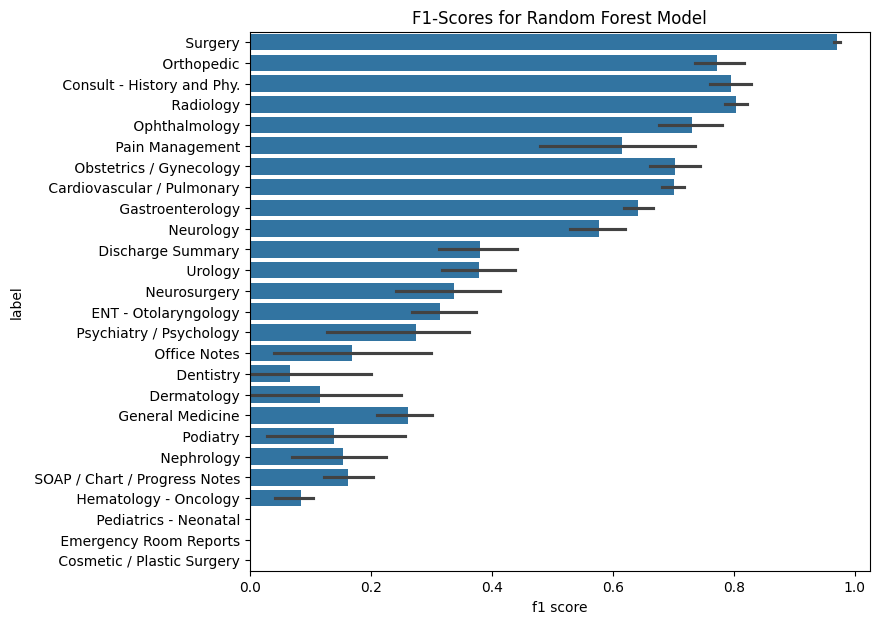

In [115]:
plot_f1_scores(f1_scores_rforest, 'Random Forest')

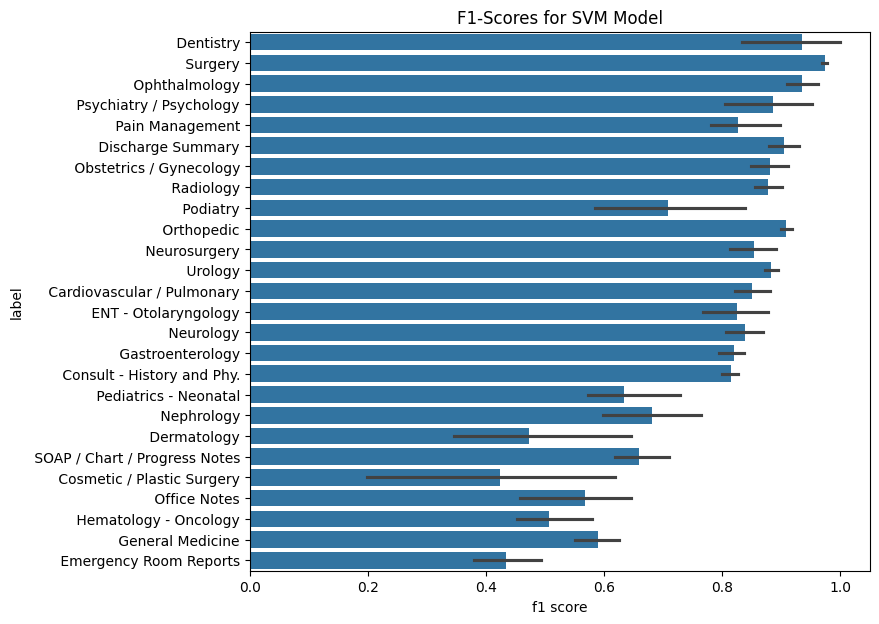

In [82]:
plot_f1_scores(f1_scores_svc, 'SVM')

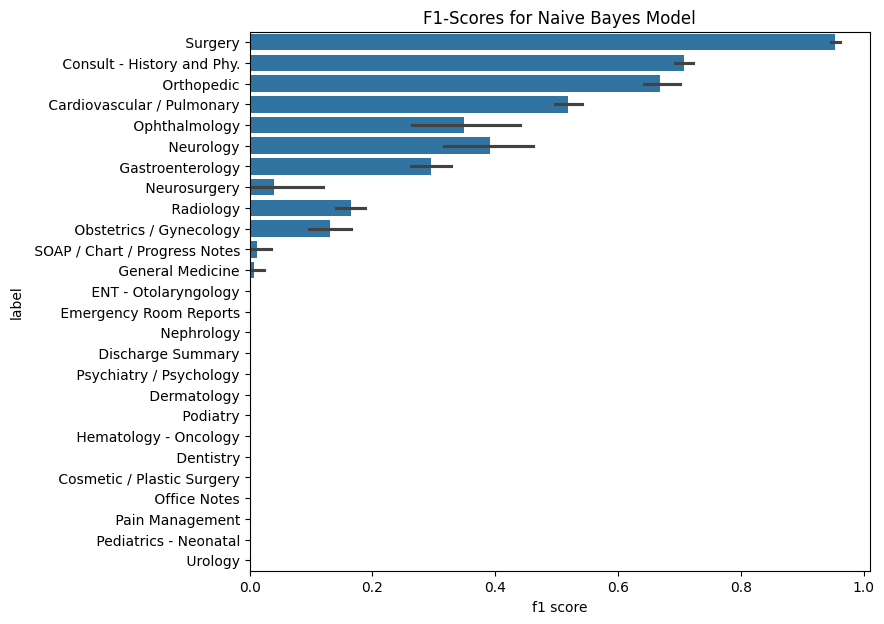

In [83]:
plot_f1_scores(f1_scores_nb, 'Naive Bayes')

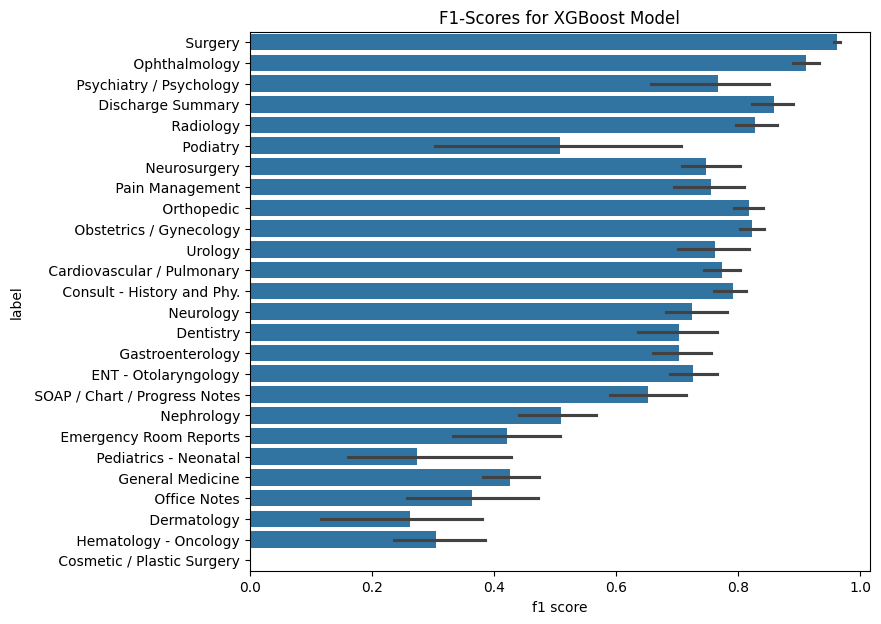

In [103]:
plot_f1_scores(f1_scores_xgboost, 'XGBoost')

## BERT

In [52]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.texts.items()}
        item['labels'] = self.labels[idx]
        return item

In [68]:
class Classifier(nn.Module):
	def __init__(self, base_model_name, n_classes, class_weights=None) -> None:
		super().__init__()
		self.model = AutoModel.from_pretrained(base_model_name)
		self.linear = nn.Linear(768, n_classes)

		self.class_weights = torch.Tensor(class_weights.values) if class_weights is not None else None

	def forward(self, input_ids, attention_mask, labels=None, **kwargs):
		x = self.model(input_ids, attention_mask, **kwargs)
		x = x.last_hidden_state[:, 0, :]
		x = self.linear(x)

		weights = None
		if self.class_weights is not None:
			self.class_weights = self.class_weights.to(labels.device)
			weights = self.class_weights.repeat(len(labels), 1)

		return SequenceClassifierOutput(
			loss=F.binary_cross_entropy_with_logits(x, labels, weights),
			logits=F.sigmoid(x)
		)

In [69]:
def compute_metrics(eval_pred):
	Y_pred, Y_test = eval_pred
	Y_pred = (Y_pred > 0.5).astype(int)
	p, r, f, _ = precision_recall_fscore_support(Y_test, Y_pred, average=None)

	p_series = pd.Series(p)
	p_series.index = 'p_' + p_series.index.astype(str)
	r_series = pd.Series(r)
	r_series.index = 'r_' + r_series.index.astype(str)
	f1_series = pd.Series(f)
	f1_series.index = 'f1_' + f1_series.index.astype(str)

	return {**p_series.to_dict(), **r_series.to_dict(), **f1_series.to_dict()}

def train_bert_models(model_name, weighted_loss=False):
	scores_filepath = f'./models/{model_name}_scores.npy'
	if os.path.exists(scores_filepath):
		scores = np.load(scores_filepath)
		return scores[0], scores[1], scores[2]

	logging.set_verbosity_warning()

	tokenizer = AutoTokenizer.from_pretrained(model_name)

	class_weights = 1 / df_ohe.sum(axis=0) if weighted_loss else None

	p_scores = np.zeros((n_splits, df_ohe.shape[1]))
	r_scores = np.zeros((n_splits, df_ohe.shape[1]))
	f1_scores = np.zeros((n_splits, df_ohe.shape[1]))
	for i, (X_train, X_test, Y_train, Y_test) in enumerate(splits):
		output_path = f'./models/{model_name}/it_{i}'
		model = Classifier(model_name, df_ohe.shape[1], class_weights)

		Y_train, Y_test = Y_train.astype('float32'), Y_test.astype('float32')
		X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, max_length=256)
		X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, max_length=256)

		training_args = TrainingArguments(
			output_dir=output_path,
			num_train_epochs=10,
			do_train=True,
			per_device_train_batch_size=32,
			learning_rate=1e-04,
			weight_decay=0.1,
			push_to_hub=False,
			logging_steps=10,
			save_total_limit=1,
			save_steps=100,
		)

		trainer = Trainer(
			model=model,
			args=training_args,
			train_dataset=Dataset(X_train_tokens, Y_train),
			tokenizer=tokenizer,
			compute_metrics=compute_metrics
		)

		trainer.train()

		prediction = trainer.predict(Dataset(X_test_tokens, Y_test), metric_key_prefix='test')
		metrics = pd.Series(prediction.metrics)

		p_metrics = metrics[metrics.index.str.startswith('test_p_')]
		p_metrics.index = p_metrics.index.str.replace('test_p_', '').astype(int)
		p_scores[i] = p_metrics.values

		r_metrics = metrics[metrics.index.str.startswith('test_r_')]
		r_metrics.index = r_metrics.index.str.replace('test_r_', '').astype(int)
		r_scores[i] = r_metrics.values

		f1_metrics = metrics[metrics.index.str.startswith('test_f1_')]
		f1_metrics.index = f1_metrics.index.str.replace('test_f1_', '').astype(int)
		f1_scores[i] = f1_metrics.values

		wandb.finish()

	scores = np.stack((p_scores, r_scores, f1_scores), axis=0)
	np.save(scores_filepath, scores)

	return p_scores, r_scores, f1_scores

In [62]:
p_scores_bert, r_scores_bert, f1_scores_bert = train_bert_models('bert-base-uncased', weighted_loss=True)

In [63]:
p_scores_biobert, r_scores_biobert, f1_scores_biobert = train_bert_models('dmis-lab/biobert-base-cased-v1.2')

In [84]:
p_scores_clinicalbert, r_scores_clinicalbert, f1_scores_clinicalbert = train_bert_models('medicalai/ClinicalBERT')

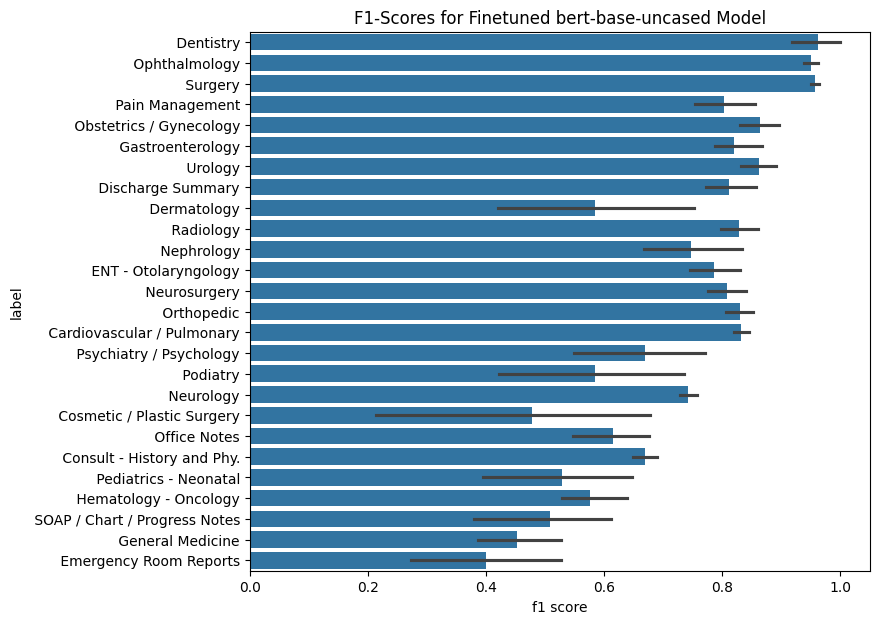

In [71]:
plot_f1_scores(f1_scores_bert, 'Finetuned bert-base-uncased')

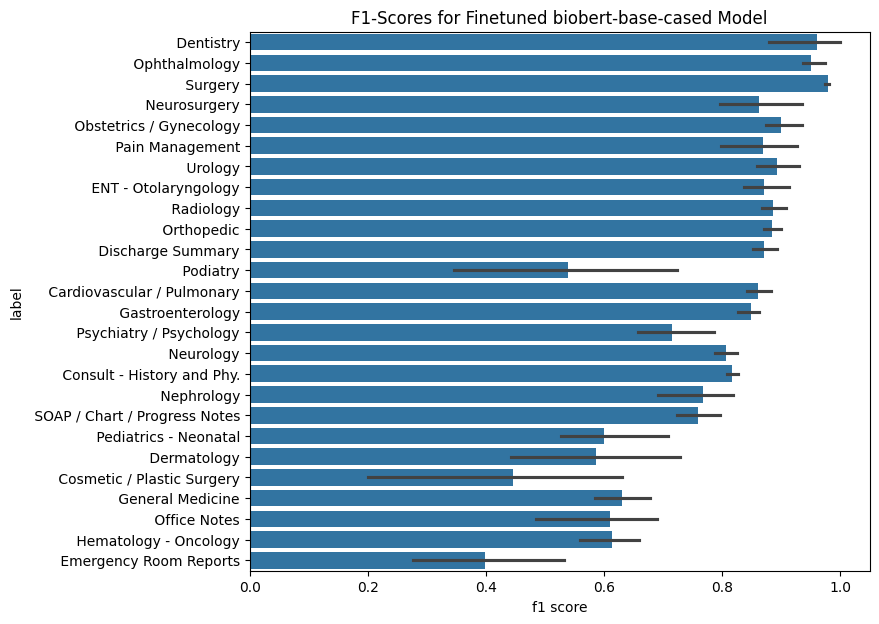

In [72]:
plot_f1_scores(f1_scores_biobert, 'Finetuned biobert-base-cased')

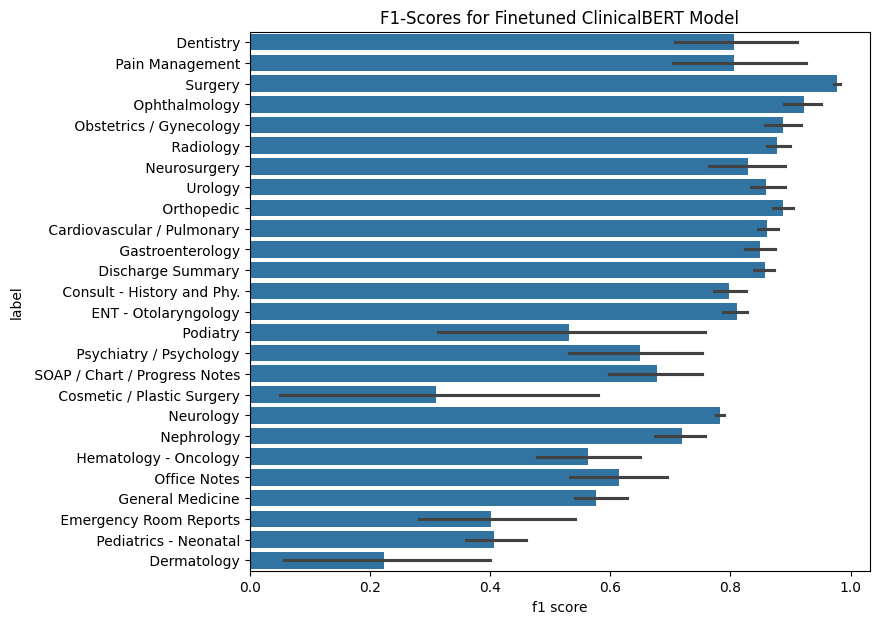

In [73]:
plot_f1_scores(f1_scores_clinicalbert, 'Finetuned ClinicalBERT')

## GPT

In [ ]:
template = """[INST] <<SYS>>

You are a helpful assistant responding to the user's classification requests. Answer in a single word: yes or no.

<</SYS>>

Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}
[/INST]"""

if not os.path.exists('./prompts/llama2-7b-v1.csv'):
	prompts = []
	for i, text in enumerate(df_ohe.index):
		for cat in df_ohe.columns:
			prompts.append({
				'index': i,
				'text': text,
				'cat': cat,
				'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
			})

	pd.DataFrame(prompts).to_csv('./prompts/llama2-7b-v1.csv')

In [ ]:
template = """[INST] <<SYS>>

You are a helpful assistant responding to the user's classification requests. Answer in a single word: yes or no.

<</SYS>>

Do you think the following text can be classified as "{category}"? Answer yes or no.

{sample_text}
[/INST]
Yes.

[INST]
Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}
[/INST]"""

if not os.path.exists('./prompts/llama2-7b-v2.csv'):
	prompts = []
	for i, text in enumerate(df_ohe.index):
		for cat in df_ohe.columns:
			sample_text = df_ohe[df_ohe[cat] == 1].drop(index=text, errors='ignore').sample(1).index.values[0]

			prompts.append({
				'index': i,
				'text': text,
				'cat': cat,
				'prompt': template.replace('{category}', cat.strip()).replace('{text}', text).replace('{sample_text}', sample_text)
			})

	pd.DataFrame(prompts).to_csv('./prompts/llama2-7b-v2.csv')

In [ ]:
template = """Answer in a single word: yes or no. Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}

Answer: """

if not os.path.exists('./prompts/meditron-7b-v1.csv'):
	prompts = []
	for i, text in enumerate(df_ohe.index):
		for cat in df_ohe.columns:
			prompts.append({
				'index': i,
				'text': text,
				'cat': cat,
				'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
			})

	pd.DataFrame(prompts).to_csv('./prompts/meditron-7b-v1.csv')

In [ ]:
template = """You are a helpful assistant responding to the user's classification requests. Answer in a single word: yes or no.

### Instruction: Do you think the following text can be classified as "{category}"? Answer yes or no.

{text}

### Response: """

if not os.path.exists('./prompts/meditron-7b-v4.csv'):
	prompts = []
	for i, text in enumerate(df_ohe.index):
		for cat in df_ohe.columns:
			prompts.append({
				'index': i,
				'text': text,
				'cat': cat,
				'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
			})

	pd.DataFrame(prompts).to_csv('./prompts/meditron-7b-v4.csv')

In [ ]:
template = """[INST]Do you think the following text can be classified as "{category}"? Answer in a single word: yes or no.

{text} [/INST]"""

if not os.path.exists('./prompts/mistral-7b-v1.csv'):
	prompts = []
	for i, text in enumerate(df_ohe.index):
		for cat in df_ohe.columns:
			prompts.append({
				'index': i,
				'text': text,
				'cat': cat,
				'prompt': template.replace('{category}', cat.strip()).replace('{text}', text)
			})

	pd.DataFrame(prompts).to_csv('./prompts/mistral-7b-v1.csv')

### Results

In [42]:
def postprocess_answers(results):
	results['answer'] = results['answer'].str.replace('\.$', '', regex=True)
	print(results['answer'].value_counts())
	print()

	tokens = results['answer'].str.lower().str.split(expand=True).stack().reset_index(level=1, drop=True).reset_index(name='token')
	tokens['yes'] = tokens['token'] == 'yes'
	tokens['no'] = tokens['token'] == 'no'

	tokens = tokens.groupby('index').sum(numeric_only=True).astype(int)

	result = tokens.idxmax(axis='columns').rename('pred')

	# tiebreaking
	result[tokens['yes'] == tokens['no']] = np.nan

	results['pred'] = result.map({'yes': 1, 'no': 0})

	print(result.value_counts(dropna=False))


In [43]:
results7b = pd.read_csv('./prompts/llama2-7b-v1.csv', index_col=0)
results7b['model'] = 'Llama 2 (7B)'
results13b = pd.read_csv('./prompts/llama2-13b-v1.csv', index_col=0)
results13b['model'] = 'Llama 2 (13B)'

print('Llama 2 (7B)')
postprocess_answers(results7b)

print()
print()
print('Llama 2 (13B)')
postprocess_answers(results13b)

Llama 2 (7B)
answer
  Yes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [44]:
pred7b = results7b.pivot(index='text', columns='cat', values='pred')
pred13b = results13b.pivot(index='text', columns='cat', values='pred')
pred13b.shape, pred7b.shape

((2357, 26), (2357, 26))

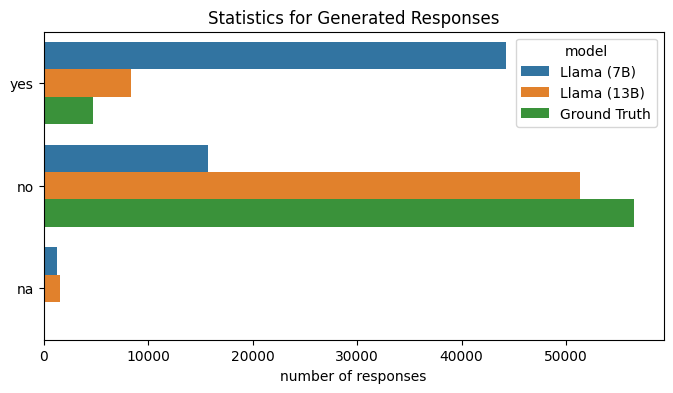

In [155]:
yes_7b = pred7b.sum().rename('yes').to_frame()
no_7b = (1 - pred7b).sum().rename('no').to_frame()
na_7b = pred7b.isna().sum().rename('na').to_frame()

yes_13b = pred13b.sum().rename('yes').to_frame()
no_13b = (1 - pred13b).sum().rename('no').to_frame()
na_13b = pred13b.isna().sum().rename('na').to_frame()

yes_true = df_ohe.sum().rename('yes').to_frame()
no_true = (1 - df_ohe).sum().rename('no').to_frame()

stats_7b = pd.concat((yes_7b, no_7b, na_7b), axis=1).sum(axis=0)
stats_7b['model'] = 'Llama (7B)'

stats_13b = pd.concat((yes_13b, no_13b, na_13b), axis=1).sum(axis=0)
stats_13b['model'] = 'Llama (13B)'

stats_true = pd.concat((yes_true, no_true), axis=1).sum(axis=0)
stats_true['model'] = 'Ground Truth'

stats_df = pd.concat((stats_7b, stats_13b, stats_true), axis=1).T
stats_df = stats_df.melt(id_vars=['model'], var_name='metric', ignore_index=False).reset_index(names='cat')

plt.figure(figsize=(8, 4))
sns.barplot(stats_df, x='value', y='metric', hue='model')
plt.title('Statistics for Generated Responses')
plt.xlabel('number of responses')
plt.ylabel('')
plt.show()

In [86]:
p_scores_7b, r_scores_7b, f1_scores_7b, support = precision_recall_fscore_support(df_ohe, pred7b.fillna(0), average=None)
p_scores_13b, r_scores_13b, f1_scores_13b, _ = precision_recall_fscore_support(df_ohe, pred13b.fillna(0), average=None)

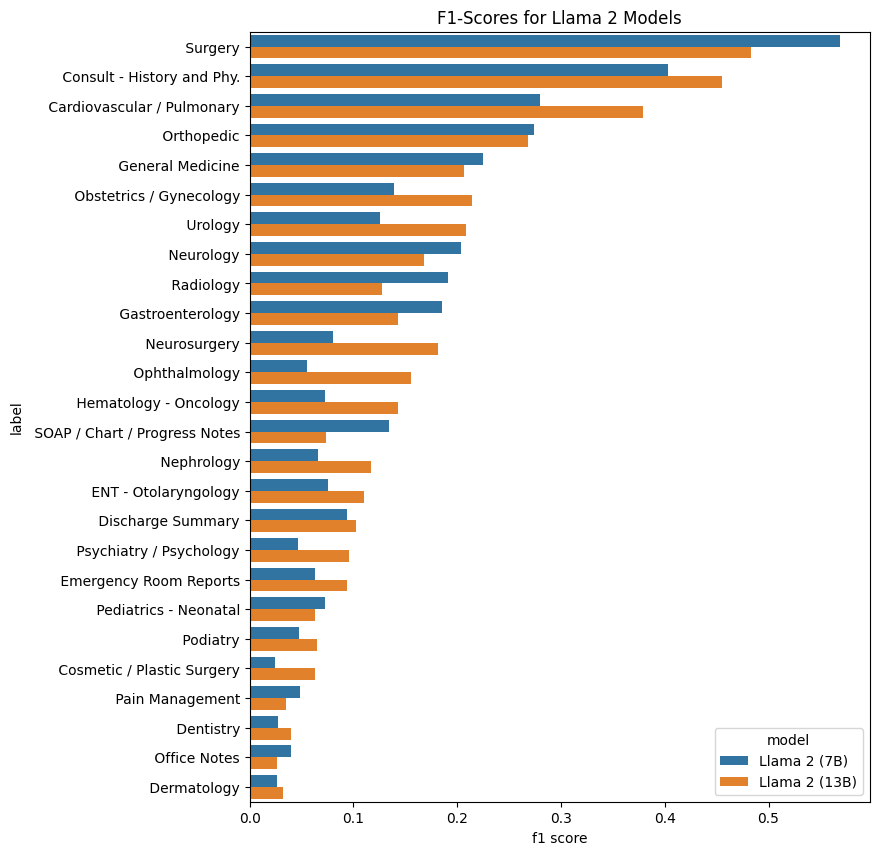

In [157]:
f1_scores_7b_df = pd.Series(f1_scores_7b, index=df_ohe.columns)
f1_scores_7b_df = f1_scores_7b_df.rename('score').to_frame().reset_index(names='label')
f1_scores_7b_df['model'] = 'Llama 2 (7B)'

f1_scores_13b_df = pd.Series(f1_scores_13b, index=df_ohe.columns)
f1_scores_13b_df = f1_scores_13b_df.rename('score').to_frame().reset_index(names='label')
f1_scores_13b_df['model'] = 'Llama 2 (13B)'

f1_scores_df = pd.concat((f1_scores_7b_df, f1_scores_13b_df))
f1_scores_df = f1_scores_df.sort_values('score', ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(f1_scores_df, x='score', y='label', hue='model')
plt.title('F1-Scores for Llama 2 Models')
plt.xlabel('f1 score')
plt.ylabel('label')
plt.show()

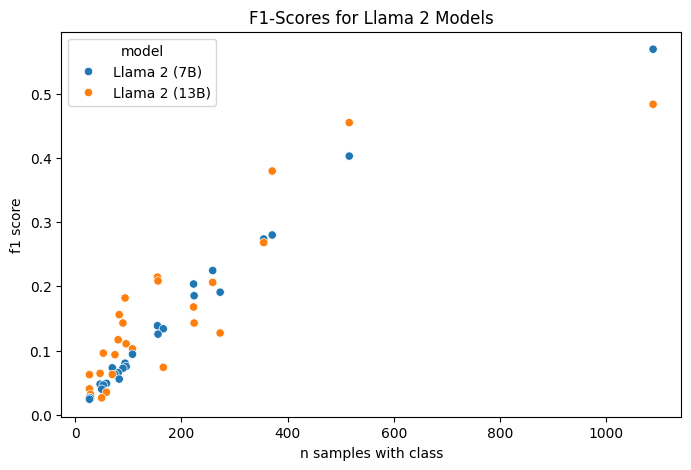

In [158]:
support_df = pd.Series(support, index=df_ohe.columns)
support_df = support_df.rename('support').to_frame().reset_index(names='label')

f1_support_scores_df = f1_scores_df.set_index('label')
f1_support_scores_df['support'] = pd.Series(support, index=df_ohe.columns)

plt.figure(figsize=(8, 5))
sns.scatterplot(f1_support_scores_df, x='support', y='score', hue='model')
plt.title('F1-Scores for Llama 2 Models')
plt.xlabel('n samples with class')
plt.ylabel('f1 score')
plt.show()

## Conclusion

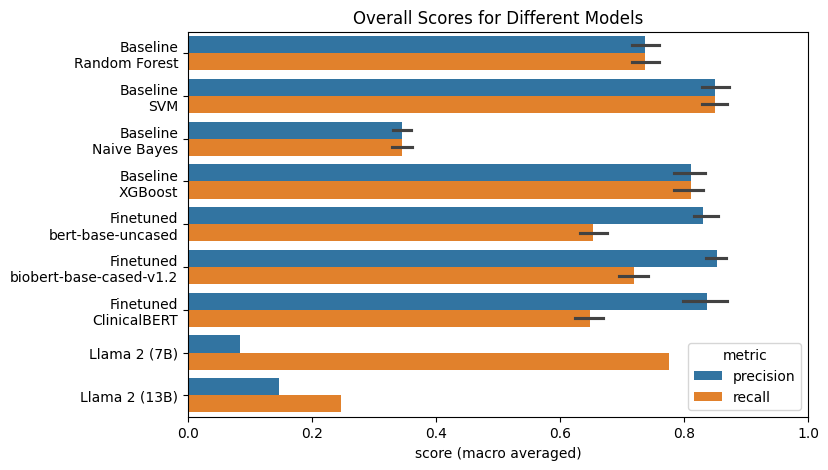

In [118]:
scores_df = pd.DataFrame([
	*({'model': 'Baseline\nRandom Forest', 'metric': 'precision', 'score': v} for v in p_scores_rforest.mean(axis=1)),
	*({'model': 'Baseline\nRandom Forest', 'metric': 'recall', 'score': v} for v in  p_scores_rforest.mean(axis=1)),
	*({'model': 'Baseline\nSVM', 'metric': 'precision', 'score': v} for v in p_scores_svc.mean(axis=1)),
	*({'model': 'Baseline\nSVM', 'metric': 'recall', 'score': v} for v in p_scores_svc.mean(axis=1)),
	*({'model': 'Baseline\nNaive Bayes', 'metric': 'precision', 'score': v} for v in p_scores_nb.mean(axis=1)),
	*({'model': 'Baseline\nNaive Bayes', 'metric': 'recall', 'score': v} for v in p_scores_nb.mean(axis=1)),
	*({'model': 'Baseline\nXGBoost', 'metric': 'precision', 'score': v} for v in p_scores_xgboost.mean(axis=1)),
	*({'model': 'Baseline\nXGBoost', 'metric': 'recall', 'score': v} for v in p_scores_xgboost.mean(axis=1)),
	*({'model': 'Finetuned\nbert-base-uncased', 'metric': 'precision', 'score': v} for v in p_scores_bert.mean(axis=1)),
	*({'model': 'Finetuned\nbert-base-uncased', 'metric': 'recall', 'score': v} for v in r_scores_bert.mean(axis=1)),
	*({'model': 'Finetuned\nbiobert-base-cased-v1.2', 'metric': 'precision', 'score': v} for v in p_scores_biobert.mean(axis=1)),
	*({'model': 'Finetuned\nbiobert-base-cased-v1.2', 'metric': 'recall', 'score': v} for v in r_scores_biobert.mean(axis=1)),
	*({'model': 'Finetuned\nClinicalBERT', 'metric': 'precision', 'score': v} for v in p_scores_clinicalbert.mean(axis=1)),
	*({'model': 'Finetuned\nClinicalBERT', 'metric': 'recall', 'score': v} for v in r_scores_clinicalbert.mean(axis=1)),
	{'model': 'Llama 2 (7B)', 'metric': 'precision', 'score': p_scores_7b.mean()},
	{'model': 'Llama 2 (7B)', 'metric': 'recall', 'score': r_scores_7b.mean()},
	{'model': 'Llama 2 (13B)', 'metric': 'precision', 'score': p_scores_13b.mean()},
	{'model': 'Llama 2 (13B)', 'metric': 'recall', 'score': r_scores_13b.mean()}
])

plt.figure(figsize=(8, 5))
sns.barplot(scores_df, x='score', y='model', hue='metric')
plt.title('Overall Scores for Different Models')
plt.xlabel('score (macro averaged)')
plt.ylabel('')
plt.xlim(0, 1)
plt.show()